In [2]:
apikey='APIKEY'

In [3]:
# DO NOT CHANGE THIS CELL
# write the config file
config_dict={'apikey': apikey, 'format_type': 'json', 'org': 'nvidia'}
with open('config', 'w') as f: 
    f.write(';WARNING - This is a machine generated file.  Do not edit manually.\n')
    f.write(';WARNING - To update local config settings, see "ngc config set -h"\n')
    f.write('\n[CURRENT]\n')
    for k, v in config_dict.items(): 
        f.write(k+'='+v+'\n')

# preview the config file
!cat config

;WARNING - This is a machine generated file.  Do not edit manually.
;WARNING - To update local config settings, see "ngc config set -h"

[CURRENT]
apikey=APIKEY
format_type=json
org=nvidia


In [3]:
# move the config file to ~/.ngc
!mkdir -p ~/.ngc & mv config ~/.ngc/

In [4]:
# login to NGC's docker registry
!docker login -u '$oauthtoken' -p $apikey nvcr.io

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /root/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded


## The Data Set ##

<a name='s1-3.1'></a>
### Sentinel-1 Data Public Access ###
The Sentinel-1 SAR data we will use is available from [ESA](https://www.esa.int/) via the [Copernicus Open Access Hub](https://scihub.copernicus.eu/). They maintain an archive and is committed to delivering data within 24 hours of acquisition and maintains recent months of data. They are also available via NASA's [EARTHDATASEARCH](https://search.earthdata.nasa.gov/) or [Vertex](https://search.asf.alaska.edu/#/), Alaska Satellite Facility's data portal. They are organized as tiles, which is the process of subdividing geographic data into pre-defined roughly-squares. Tile-based mapping efficiently renders, stores, and retrieves image data. 
<p><img src='images/sentinel-1_capture.png' width=720></p>

In [5]:
# unzip data file
!unzip data/flood_data.zip -d data

Archive:  data/flood_data.zip
  inflating: data/Sen1Floods11_Metadata.geojson  
   creating: data/catalog/
   creating: data/catalog/sen1floods11_hand_labeled_source/
   creating: data/catalog/sen1floods11_hand_labeled_source/Ghana_953791/
  inflating: data/catalog/sen1floods11_hand_labeled_source/Ghana_953791/Ghana_953791.json  
   creating: data/catalog/sen1floods11_hand_labeled_source/Pakistan_210595/
  inflating: data/catalog/sen1floods11_hand_labeled_source/Pakistan_210595/Pakistan_210595.json  
   creating: data/catalog/sen1floods11_hand_labeled_source/USA_198411/
  inflating: data/catalog/sen1floods11_hand_labeled_source/USA_198411/USA_198411.json  
   creating: data/catalog/sen1floods11_hand_labeled_source/Pakistan_740461/
  inflating: data/catalog/sen1floods11_hand_labeled_source/Pakistan_740461/Pakistan_740461.json  
   creating: data/catalog/sen1floods11_hand_labeled_source/Pakistan_401863/
  inflating: data/catalog/sen1floods11_hand_labeled_source/Pakistan_401863/Pakistan_4

In [6]:
# import dependencies
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

# set environment variables
%set_env LOCAL_DATA_DIR=/dli/task/data

# set paths for images and masks
image_dir=os.path.join(os.getenv('LOCAL_DATA_DIR'), 'images')
mask_dir=os.path.join(os.getenv('LOCAL_DATA_DIR'), 'masks')

env: LOCAL_DATA_DIR=/dli/task/data


In [7]:
# define function to count number of images per region
def count_num_images(file_dir): 
    """
    This function returns a dictionary representing the count of images for each region as the key. 
    """
    # list all files in the directory
    file_list=os.listdir(file_dir)
    region_count={}
    # iterate through the file_list and count by region
    for file_name in file_list: 
        region=file_name.split('_')[0]
        if (len(file_name.split('.'))==2) and (region in region_count): 
            region_count[region]+=1
        elif len(file_name.split('.'))==2: 
            region_count[region]=1
    return region_count

In [8]:
# count images and masks by region
images_count=count_num_images(os.path.join(image_dir, 'all_images'))
masks_count=count_num_images(os.path.join(mask_dir, 'all_masks'))

# display counts
print(f'-----number of images: {sum(images_count.values())}-----')
display(sorted(images_count.items(), key=lambda x: x[1]))

print(f'-----number of masks: {sum(masks_count.values())}-----')
display(sorted(masks_count.items(), key=lambda x: x[1]))

-----number of images: 446-----


[('Bolivia', 15),
 ('Nigeria', 18),
 ('Somalia', 26),
 ('Pakistan', 28),
 ('Spain', 30),
 ('Mekong', 30),
 ('Sri-Lanka', 42),
 ('Ghana', 53),
 ('Paraguay', 67),
 ('India', 68),
 ('USA', 69)]

-----number of masks: 446-----


[('Bolivia', 15),
 ('Nigeria', 18),
 ('Somalia', 26),
 ('Pakistan', 28),
 ('Spain', 30),
 ('Mekong', 30),
 ('Sri-Lanka', 42),
 ('Ghana', 53),
 ('Paraguay', 67),
 ('India', 68),
 ('USA', 69)]

In [9]:
# define function to get coordinates from catalog
def get_coordinates(catalog_dir): 
    """
    This function returns a list of boundaries for every image as [[lon, lat], [lon, lat], [lon, lat], etc.] in the catalog. 
    """
    catalog_list=os.listdir(catalog_dir)
    all_coordinates=[]
    for catalog in catalog_list: 
        # check if it's a directory based on if file_name has an extension
        if len(catalog.split('.'))==1:
            catalog_path=f'{catalog_dir}/{catalog}/{catalog}.json'
            # read catalog
            with open(catalog_path) as f: 
                catalog_json=json.load(f)
            # parse out coordinates
            coordinates_list=catalog_json['geometry']['coordinates'][0]
            lon=[coordinates[0] for coordinates in coordinates_list]
            all_coordinates.append(lon)
            lat=[coordinates[1] for coordinates in coordinates_list]
            all_coordinates.append(lat)
    return all_coordinates

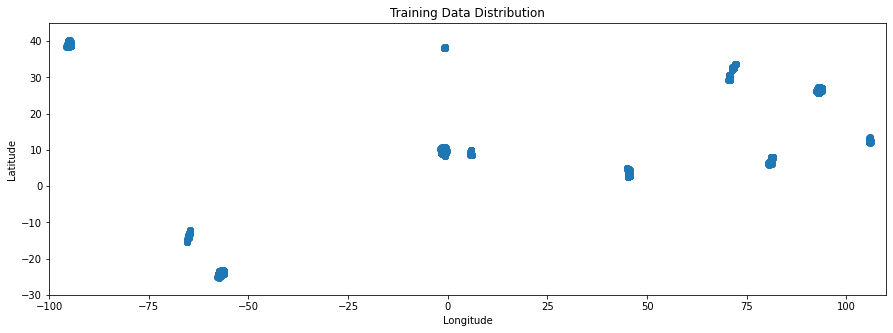

In [10]:
# set paths for images catalog
image_catalog_dir=os.path.join(os.getenv('LOCAL_DATA_DIR'), 'catalog', 'sen1floods11_hand_labeled_source')
image_coordinates_list=get_coordinates(image_catalog_dir)

# flatten lat and lon coordinate lists
image_lon=[image_coordinates_list[x] for x in range(len(image_coordinates_list)) if x%2==0]
image_lon=np.concatenate(image_lon).ravel()
image_lat=[image_coordinates_list[x] for x in range(len(image_coordinates_list)) if x%2==1]
image_lat=np.concatenate(image_lat).ravel()

plt.figure(figsize=(15, 5))

plt.scatter(image_lon, image_lat)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Training Data Distribution')
plt.xlim([-100, 110])
plt.ylim([-30, 45])
plt.show()

In [11]:
# define function to get extent of an image from catalog
def get_extent(file_path): 
    """
    This function returns the extent as [left, right, bottom, top] for a given image. 
    """
    # read catalog for image
    with open(file_path) as f: 
        catalog_json=json.load(f)
    coordinates=catalog_json['geometry']['coordinates'][0]
    coordinates=np.array(coordinates)
    # get boundaries
    left=np.min(coordinates[:, 0])
    right=np.max(coordinates[:, 0])
    bottom=np.min(coordinates[:, 1])
    top=np.max(coordinates[:, 1])
    return left, right, bottom, top

In [12]:
# define function to plot by region
def tiles_by_region(country_name, plot_type='images'): 
    # set catalog and images/masks path
    catalog_dir=os.path.join(os.getenv('LOCAL_DATA_DIR'), 'catalog', 'sen1floods11_hand_labeled_source')
    if plot_type=='images': 
        dir=os.path.join(image_dir, 'all_images')
        cmap='viridis'
    elif plot_type=='masks': 
        dir=os.path.join(mask_dir, 'all_masks')
        cmap='gray'
    else: 
        raise Exception('Bad Plot Type')

    # initiate figure boundaries, which will be modified based on the extent of the tiles
    x_min, x_max, y_min, y_max=181, -181, 91, -91
    fig=plt.figure(figsize=(15, 15))
    ax=plt.subplot(111)
    
    # iterate through each image/mask and plot
    file_list=os.listdir(dir)
    for each_file in file_list:
        # check if image/mask is related to region and a .png file
        if (each_file.split('.')[-1]=='png') & (each_file.split('_')[0]==country_name): 
            # get boundaries of the image
            extent=get_extent(f"{catalog_dir}/{each_file.split('.')[0]}/{each_file.split('.')[0]}.json")
            x_min, x_max=min(extent[0], x_min), max(extent[1], x_max)
            y_min, y_max=min(extent[2], y_min), max(extent[3], y_max)
            image=mpimg.imread(f'{dir}/{each_file}')
            plt.imshow(image, extent=extent, cmap=cmap)
    
    # set boundaries of the axis
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    plt.show()

In [13]:
# define function to plot by boundaries
def tiles_by_boundaries(top_left, bottom_right, plot_type='images'): 
    # set catalog and images/masks path
    catalog_dir=os.path.join(os.getenv('LOCAL_DATA_DIR'), 'catalog', 'sen1floods11_hand_labeled_source')
    if plot_type=='images': 
        dir=os.path.join(image_dir, 'all_images')
        cmap='viridis'
    elif plot_type=='masks': 
        dir=os.path.join(mask_dir, 'all_masks')
        cmap='gray'
    else: 
        raise Exception('Bad Plot Type')

    # initiate figure boundaries, which will be modified based on the extent of the tiles
    x_min, x_max, y_min, y_max=top_left[0], bottom_right[0], bottom_right[1], top_left[1]
    ax_x_min, ax_x_max, ax_y_min, ax_y_max=181, -181, 91, -91

    fig=plt.figure(figsize=(15, 15))
    ax=plt.subplot(111)

    # iterate through each image/mask and plot
    file_list=os.listdir(dir)
    for each_file in file_list: 
        # check if image/mask is a .png file
        if each_file.split('.')[-1]=='png': 
            # get boundaries of the image/mask
            extent=get_extent(f"{catalog_dir}/{each_file.split('.')[0]}/{each_file.split('.')[0]}.json")
            (left, right, bottom, top)=extent
            if (left>x_min) & (right<x_max) & (bottom>y_min) & (top<y_max):
                ax_x_min, ax_x_max=min(left, ax_x_min), max(right, ax_x_max)
                ax_y_min, ax_y_max=min(bottom, ax_y_min), max(top, ax_y_max)
                image=mpimg.imread(f'{dir}/{each_file}')
                plt.imshow(image, extent=extent, cmap=cmap)

    # set boundaries of the axis
    ax.set_xlim([ax_x_min, ax_x_max])
    ax.set_ylim([ax_y_min, ax_y_max])
    plt.show()

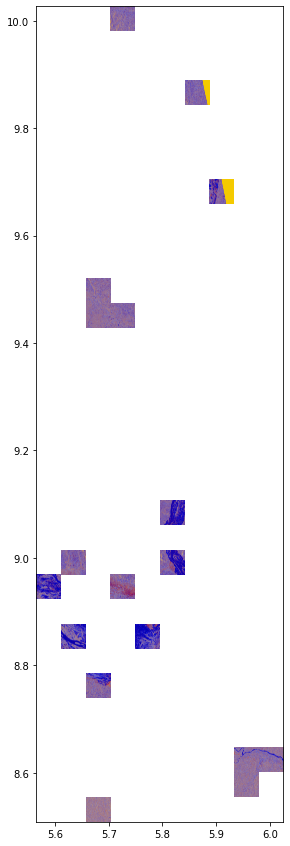

In [14]:
tiles_by_region('Nigeria')

## Pre-processing With DALI ##

<p><img src='images/dali.png' width=720></p>


In [37]:
# import dependencies
from nvidia.dali.pipeline import Pipeline
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types

import warnings
warnings.filterwarnings("ignore")

In [38]:
# DO NOT CHANGE THIS CELL
batch_size=4

@pipeline_def
def simple_pipeline():
    # use fn.readers.file to read encoded images and labels from the hard drive
    pngs, labels=fn.readers.file(file_root=image_dir)
    # use the fn.decoders.image operation to decode images from png to RGB
    images=fn.decoders.image(pngs, device='cpu')
    # specify which of the intermediate variables should be returned as the outputs of the pipeline
    return images, labels


In [39]:
# create and build pipeline
pipe=simple_pipeline(batch_size=batch_size, num_threads=4, device_id=0)
pipe.build()

In [40]:
# run the pipeline
simple_pipe_output=pipe.run()

images, labels=simple_pipe_output
print("Images is_dense_tensor: " + str(images.is_dense_tensor()))
print("Labels is_dense_tensor: " + str(labels.is_dense_tensor()))

Images is_dense_tensor: True
Labels is_dense_tensor: True


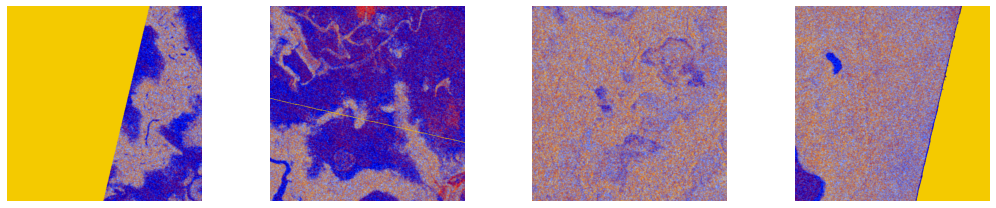

In [41]:
# define a function display images
def show_images(image_batch):
    columns=4
    rows=1
    # create plot
    fig=plt.figure(figsize=(15, (15 // columns) * rows))
    gs=gridspec.GridSpec(rows, columns)
    for idx in range(rows*columns):
        plt.subplot(gs[idx])
        plt.axis("off")
        plt.imshow(image_batch.at(idx))
    plt.tight_layout()

show_images(images)

In [42]:
import random

@pipeline_def
def augmentation_pipeline():
    # use fn.readers.file to read encoded images and labels from the hard drive
    image_pngs, _=fn.readers.file(file_root=image_dir)
    # use the fn.decoders.image operation to decode images from png to RGB
    images=fn.decoders.image(image_pngs, device='cpu')
    
    # the same augmentation needs to be performed on the associated masks
    mask_pngs, _=fn.readers.file(file_root=mask_dir)
    masks=fn.decoders.image(mask_pngs, device='cpu')
    
    image_size=512
    roi_size=image_size*.5
    roi_start_x=image_size*random.uniform(0, 0.5)
    roi_start_y=image_size*random.uniform(0, 0.5)
    
    # use fn.resize to investigate an roi, region of interest
    resized_images=fn.resize(images, size=[512, 512], roi_start=[roi_start_x, roi_start_y], roi_end=[roi_start_x+roi_size, roi_start_y+roi_size])
    resized_masks=fn.resize(masks, size=[512, 512], roi_start=[roi_start_x, roi_start_y], roi_end=[roi_start_x+roi_size, roi_start_y+roi_size])
    
    # use fn.resize to flip the image
    flipped_images=fn.resize(images, size=[-512, -512])
    flipped_masks=fn.resize(masks, size=[-512, -512])
    return images, resized_images, flipped_images, masks, resized_masks, flipped_masks

In [43]:
pipe=augmentation_pipeline(batch_size=batch_size, num_threads=4, device_id=0)
pipe.build()
augmentation_pipe_output=pipe.run()

In [44]:
# define a function display images
def show_augmented_images(pipe_output):
    image_batch, resized_image_batch, flipped_image_batch, mask_batch, resized_mask_batch, flipped_mask_batch=pipe_output
    columns=6
    rows=batch_size
    # create plot
    fig=plt.figure(figsize=(15, (15 // columns) * rows))
    gs=gridspec.GridSpec(rows, columns)
    grid_data=[image_batch, resized_image_batch, flipped_image_batch, mask_batch, resized_mask_batch, flipped_mask_batch]
    grid=0
    for row_idx in range(rows): 
        for col_idx in range(columns): 
            plt.subplot(gs[grid])
            plt.axis('off')
            plt.imshow(grid_data[col_idx].at(row_idx))
            grid+=1
    plt.tight_layout()

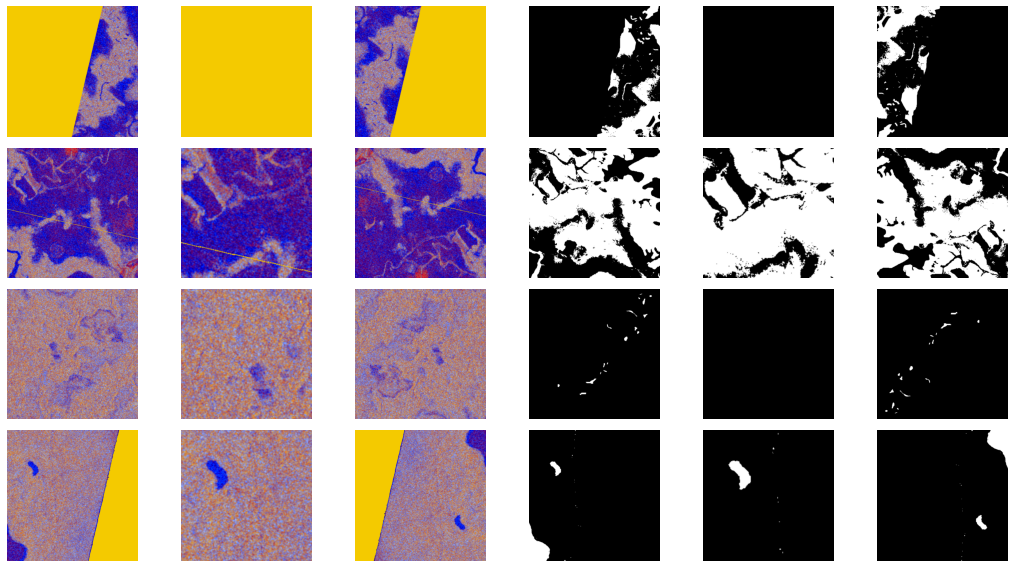

In [45]:
show_augmented_images(augmentation_pipe_output)

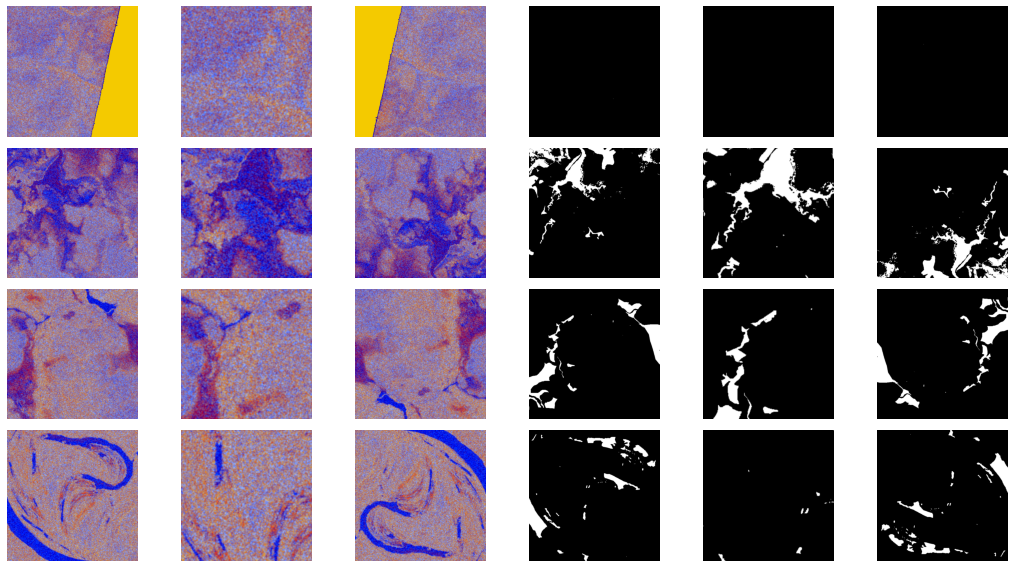

In [46]:
show_augmented_images(pipe.run())

In [47]:
@pipeline_def
def rotate_pipeline():
    images, _=fn.readers.file(file_root=image_dir)
    masks, _=fn.readerAs.file(file_root=mask_dir)
    images=fn.decoders.image(images, device='cpu')
    masks=fn.decoders.image(masks, device='cpu')
    
    angle=fn.random.uniform(range=(-30.0, 30.0))
    rotated_images = fn.rotate(images.gpu(), angle=angle, fill_value=0, keep_size=True, device='gpu')
    rotated_masks = fn.rotate(masks.gpu(), angle=angle, fill_value=0, keep_size=True, device='gpu')
    
    return rotated_images, rotated_masks

In [50]:
# DO NOT CHANGE THIS CELL
pipe=rotate_pipeline(batch_size=batch_size, num_threads=4, device_id=0)
pipe.build()
rotate_pipe_output= pipe.run()

In [52]:
# set environment variables
import os

%set_env KEY=my_model_key

%set_env LOCAL_PROJECT_DIR=/dli/task/tao_project
%set_env LOCAL_DATA_DIR=/dli/task/data
%set_env LOCAL_SPECS_DIR=/dli/task/tao_project/spec_files
os.environ["LOCAL_EXPERIMENT_DIR"]=os.path.join(os.getenv("LOCAL_PROJECT_DIR"), "unet")

%set_env TAO_PROJECT_DIR=/workspace/tao-experiments
%set_env TAO_DATA_DIR=/workspace/tao-experiments/data
%set_env TAO_SPECS_DIR=/workspace/tao-experiments/spec_files
%set_env TAO_EXPERIMENT_DIR=/workspace/tao-experiments/unet

!mkdir $LOCAL_EXPERIMENT_DIR

env: KEY=my_model_key
env: LOCAL_PROJECT_DIR=/dli/task/tao_project
env: LOCAL_DATA_DIR=/dli/task/data
env: LOCAL_SPECS_DIR=/dli/task/tao_project/spec_files
env: TAO_PROJECT_DIR=/workspace/tao-experiments
env: TAO_DATA_DIR=/workspace/tao-experiments/data
env: TAO_SPECS_DIR=/workspace/tao-experiments/spec_files
env: TAO_EXPERIMENT_DIR=/workspace/tao-experiments/unet
mkdir: cannot create directory ‘/dli/task/tao_project/unet’: File exists


In [53]:
# mapping up the local directories to the TAO docker
import json
mounts_file = os.path.expanduser("~/.tao_mounts.json")

drive_map = {
    "Mounts": [
            # Mapping the data directory
            {
                "source": os.environ["LOCAL_PROJECT_DIR"],
                "destination": "/workspace/tao-experiments"
            },
            # Mapping the specs directory.
            {
                "source": os.environ["LOCAL_SPECS_DIR"],
                "destination": os.environ["TAO_SPECS_DIR"]
            },
            # Mapping the data directory.
            {
                "source": os.environ["LOCAL_DATA_DIR"],
                "destination": os.environ["TAO_DATA_DIR"]
            },
        ],
    "DockerOptions": {
        "user": "{}:{}".format(os.getuid(), os.getgid())
    }
}

# writing the mounts file
with open(mounts_file, "w") as mfile:
    json.dump(drive_map, mfile, indent=4)

### Download Pre-trained Model ###


In [54]:
# create directory to store the pre-trained model
!mkdir -p $LOCAL_EXPERIMENT_DIR/pretrained_resnet18/

# download the pre-trained segmentation model from NGC
!ngc registry model download-version nvidia/tao/pretrained_semantic_segmentation:resnet18 \
    --dest $LOCAL_EXPERIMENT_DIR/pretrained_resnet18 

{
    "download_end": "2022-07-31 18:03:43.914752",
    "download_start": "2022-07-31 18:03:37.906017",
    "download_time": "6s",
    "files_downloaded": 1,
    "local_path": "/dli/task/tao_project/unet/pretrained_resnet18/pretrained_semantic_segmentation_vresnet18-1",
    "size_downloaded": "82.38 MB",
    "status": "Completed",
    "transfer_id": "pretrained_semantic_segmentation_vresnet18"
}


In [55]:
# remove existing splits
!rm -rf $LOCAL_DATA_DIR/images/train
!mkdir -p $LOCAL_DATA_DIR/images/train
!rm -rf $LOCAL_DATA_DIR/images/val
!mkdir -p $LOCAL_DATA_DIR/images/val

!rm -rf $LOCAL_DATA_DIR/masks/train
!mkdir -p $LOCAL_DATA_DIR/masks/train
!rm -rf $LOCAL_DATA_DIR/masks/val
!mkdir -p $LOCAL_DATA_DIR/masks/val

In [56]:
# import dependencies
from random import sample
import shutil
# define split ratio
split=0.75

# get all images
file_list=os.listdir(f"{os.environ['LOCAL_DATA_DIR']}/images/all_images")
image_count=len(file_list)
train_image_list=sample(file_list, int(image_count*split))
val_image_list=[file for file in file_list if file not in train_image_list]

# move all training images to train directory
for each_file in train_image_list: 
    if each_file.split('.')[-1]=='png': 
        shutil.copyfile(f"{os.environ['LOCAL_DATA_DIR']}/images/all_images/{each_file}", f"{os.environ['LOCAL_DATA_DIR']}/images/train/{each_file}")
        shutil.copyfile(f"{os.environ['LOCAL_DATA_DIR']}/masks/all_masks/{each_file}", f"{os.environ['LOCAL_DATA_DIR']}/masks/train/{each_file}")

# move all validation images to val directory
for each_file in val_image_list: 
    if each_file.split('.')[-1]=='png': 
        shutil.copyfile(f"{os.environ['LOCAL_DATA_DIR']}/images/all_images/{each_file}", f"{os.environ['LOCAL_DATA_DIR']}/images/val/{each_file}")
        shutil.copyfile(f"{os.environ['LOCAL_DATA_DIR']}/masks/all_masks/{each_file}", f"{os.environ['LOCAL_DATA_DIR']}/masks/val/{each_file}")

In [57]:
# combining configuration components in separate files and writing into one
!cat $LOCAL_SPECS_DIR/resnet18/dataset_config.txt \
     $LOCAL_SPECS_DIR/resnet18/model_config.txt \
     $LOCAL_SPECS_DIR/resnet18/training_config.txt \
     > $LOCAL_SPECS_DIR/resnet18/combined_config.txt
!cat $LOCAL_SPECS_DIR/resnet18/combined_config.txt

dataset_config {
  dataset: "custom"
  augment: True
  augmentation_config {
    spatial_augmentation {
      hflip_probability : 0.5
      vflip_probability : 0.5
      crop_and_resize_prob : 0.5
    }
  }
  input_image_type: "color"
  train_images_path:"/workspace/tao-experiments/data/images/train"
  train_masks_path:"/workspace/tao-experiments/data/masks/train"

  val_images_path:"/workspace/tao-experiments/data/images/val"
  val_masks_path:"/workspace/tao-experiments/data/masks/val"
  
  test_images_path:"/workspace/tao-experiments/data/images/val"
  
  data_class_config {
    target_classes {
      name: "notflood"
      mapping_class: "notflood"
      label_id: 0
    }
    target_classes {
      name: "flood"
      mapping_class: "flood"
      label_id: 255
    }
  }
}
########## LEAVE NEW LINE BELOW
model_config {
  model_input_width: 512
  model_input_height: 512
  model_input_channels: 3
  num_layers: 18
  all_projections: True
  arch: "resnet"
  use_batch_norm: False
  traini

In [58]:
!cat $LOCAL_SPECS_DIR/resnet18/dataset_config.txt \
     $LOCAL_SPECS_DIR/resnet18/model_config.txt \
     $LOCAL_SPECS_DIR/resnet18/training_config.txt \
     > $LOCAL_SPECS_DIR/resnet18/combined_config.txt
!cat $LOCAL_SPECS_DIR/resnet18/combined_config.txt

dataset_config {
  dataset: "custom"
  augment: True
  augmentation_config {
    spatial_augmentation {
      hflip_probability : 0.5
      vflip_probability : 0.5
      crop_and_resize_prob : 0.5
    }
  }
  input_image_type: "color"
  train_images_path:"/workspace/tao-experiments/data/images/train"
  train_masks_path:"/workspace/tao-experiments/data/masks/train"

  val_images_path:"/workspace/tao-experiments/data/images/val"
  val_masks_path:"/workspace/tao-experiments/data/masks/val"
  
  test_images_path:"/workspace/tao-experiments/data/images/val"
  
  data_class_config {
    target_classes {
      name: "notflood"
      mapping_class: "notflood"
      label_id: 0
    }
    target_classes {
      name: "flood"
      mapping_class: "flood"
      label_id: 255
    }
  }
}
########## LEAVE NEW LINE BELOW
model_config {
  model_input_width: 512
  model_input_height: 512
  model_input_channels: 3
  num_layers: 18
  all_projections: True
  arch: "resnet"
  use_batch_norm: False
  traini

In [59]:
!rm -rf $LOCAL_EXPERIMENT_DIR/resnet18

In [60]:
# train model
!tao unet train -e $TAO_SPECS_DIR/resnet18/combined_config.txt \
                -r $TAO_EXPERIMENT_DIR/resnet18 \
                -n resnet18 \
                -m $TAO_EXPERIMENT_DIR/pretrained_resnet18/pretrained_semantic_segmentation_vresnet18/resnet_18.hdf5 \
                -k $KEY

2022-07-31 18:05:03,647 [INFO] root: Registry: ['nvcr.io']
2022-07-31 18:05:03,762 [INFO] tlt.components.instance_handler.local_instance: Running command in container: nvcr.io/nvidia/tao/tao-toolkit-tf:v3.21.11-tf1.15.5-py3
Using TensorFlow backend.
Using TensorFlow backend.




Loading experiment spec at /workspace/tao-experiments/spec_files/resnet18/combined_config.txt.
2022-07-31 18:05:08,898 [INFO] __main__: Loading experiment spec at /workspace/tao-experiments/spec_files/resnet18/combined_config.txt.
2022-07-31 18:05:08,899 [INFO] iva.unet.spec_handler.spec_loader: Merging specification from /workspace/tao-experiments/spec_files/resnet18/combined_config.txt
2022-07-31 18:05:08,900 [INFO] root: Initializing the pre-trained weights from /workspace/tao-experiments/unet/pretrained_resnet18/pretrained_semantic_segmentation_vresnet18/resnet_18.hdf5

2022-07-31 18:05:08,903 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name

In [61]:
print('Model for every epoch at checkpoint_interval mentioned in the spec file:')
print('---------------------')
!ls -ltrh $LOCAL_EXPERIMENT_DIR/resnet18/
!ls -ltrh $LOCAL_EXPERIMENT_DIR/resnet18/weights

Model for every epoch at checkpoint_interval mentioned in the spec file:
---------------------
total 366M
-rw-r--r-- 1 root root 1.4K Jul 31 18:05 experiment_spec.txt
-rw-r--r-- 1 root root   35 Jul 31 18:05 target_class_id_mapping.json
-rw-r--r-- 1 root root 3.1M Jul 31 18:05 graph.pbtxt
-rw-r--r-- 1 root root 180M Jul 31 18:05 model.step-0.tlt
-rw-r--r-- 1 root root  193 Jul 31 18:11 monitor.json
-rw-r--r-- 1 root root 180M Jul 31 18:11 model.step-3340.tlt
-rw-r--r-- 1 root root 4.2M Jul 31 18:11 events.out.tfevents.1659290712.fbdaaf6d2fec
drwxr-xr-x 2 root root 4.0K Jul 31 18:11 weights
-rw-r--r-- 1 root root  45K Jul 31 18:11 output.log
-rw-r--r-- 1 root root  224 Jul 31 18:11 profile_log.txt
total 180M
-rw-r--r-- 1 root root 180M Jul 31 18:11 resnet18.tlt


In [62]:
# evaluate the model using the same validation set as training
!tao unet evaluate -e $TAO_SPECS_DIR/resnet18/combined_config.txt\
                   -m $TAO_EXPERIMENT_DIR/resnet18/weights/resnet18.tlt \
                   -o $TAO_EXPERIMENT_DIR/resnet18/ \
                   -k $KEY

2022-07-31 18:12:04,049 [INFO] root: Registry: ['nvcr.io']
2022-07-31 18:12:04,185 [INFO] tlt.components.instance_handler.local_instance: Running command in container: nvcr.io/nvidia/tao/tao-toolkit-tf:v3.21.11-tf1.15.5-py3
Using TensorFlow backend.
Using TensorFlow backend.


2022-07-31 18:12:08,978 [INFO] __main__: Loading experiment spec at /workspace/tao-experiments/spec_files/resnet18/combined_config.txt.
2022-07-31 18:12:08,979 [INFO] iva.unet.spec_handler.spec_loader: Merging specification from /workspace/tao-experiments/spec_files/resnet18/combined_config.txt

2022-07-31 18:12:08,980 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:153: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

2022-07-31 18:12:08,993 [INFO] iva.unet.model.utilities: Label Id 0: Train Id 0
2022-07-31 18:12:08,993 [INFO] iva.unet.model.utilities: Label Id 255: Train Id 1

Phase val: Total 112 files.
2022-0

In [63]:
# remove any previous inference
!rm -rf $LOCAL_PROJECT_DIR/tao_infer_testing/*

In [64]:
# import dependencies
import matplotlib.pyplot as plt
import random

# define simple grid visualizer
def visualize_images(num_images=10):
    overlay_path=os.path.join(os.environ['LOCAL_PROJECT_DIR'], 'tao_infer_testing', 'vis_overlay_tlt')
    inference_path=os.path.join(os.environ['LOCAL_PROJECT_DIR'], 'tao_infer_testing', 'mask_labels_tlt')
    actual_path=os.path.join(os.environ['LOCAL_DATA_DIR'], 'masks', 'val')
    inference_images_path=os.path.join(os.environ['LOCAL_DATA_DIR'], 'images', 'val')
        
    fig_dim=4
    fig, ax_arr=plt.subplots(num_images, 4, figsize=[4*fig_dim, num_images*fig_dim], sharex=True, sharey=True)
    ax_arr[0, 0].set_title('Overlay')
    ax_arr[0, 1].set_title('Input')
    ax_arr[0, 2].set_title('Inference')
    ax_arr[0, 3].set_title('Actual')
    ax_arr[0, 0].set_xticks([])
    ax_arr[0, 0].set_yticks([])
    
    for idx, img_name in enumerate(random.sample(os.listdir(actual_path), num_images)):
        ax_arr[idx, 0].imshow(plt.imread(overlay_path+'/'+img_name))
        ax_arr[idx, 0].set_ylabel(img_name)
        ax_arr[idx, 1].imshow(plt.imread(inference_images_path+'/'+img_name))
        ax_arr[idx, 2].imshow(plt.imread(inference_path+'/'+img_name), cmap='gray')
        ax_arr[idx, 3].imshow(plt.imread(actual_path+'/'+img_name), cmap='gray')
    fig.tight_layout()

In [4]:
# visualizing random images
NUM_IMAGES = 4

# visualize_images(NUM_IMAGES)